### Group 28 members:
- Jingze Tian (CCID)
- Letian Ren (CCID)
- Essam Gouda (egouda)

# Task 2: Classification
- Logistic Regression model for female OR male mosquito = function(weather_features)
- Support Vector Machine model for female OR male mosquito = function(weather_features)
- Random Forest model for female OR male mosquito = function(weather_features)

#### Variations for each model:
- 10-fold cross validation for each model was performed
- t-test and ANOVA were used to compare model's performance

# Imports

In [32]:
import pandas as pd
import numpy as np
import time
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from _datetime import datetime

import warnings; warnings.simplefilter('ignore')

# Read csv files (datasets)

In [33]:
weather_data = pd.read_csv('./data/weather_data.csv')
mos_data = pd.read_csv('./data/mosquito_data_new.csv')

In [34]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,09/15/2015 12:00:00 AM,Aedes,vexans,Female,NaN,3,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
1,05/12/1998 12:00:00 AM,Male,UnID,Male,UnID,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
2,08/28/2001 12:00:00 AM,Culex,tarsalis,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
3,08/17/2004 12:00:00 AM,Culex,territans,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
4,05/15/2018 12:00:00 AM,Culiseta,impatiens,Female,NaN,2,Rural-West,NaN,Outer,53.559020,-114.001190,POINT (-114.00119 53.559020000000004)


In [35]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
0,2018-12-18 16:00:00 MST,1545174000,91.73,99.7,SW,23.0,5.0,NaN,64.0,-7.3,-1.3,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-18 15:00:00 MST,1545170400,91.67,99.7,S,18.0,5.0,NaN,65.0,-6.3,-0.5,-2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,2018-12-18 14:00:00 MST,1545166800,91.67,99.6,S,17.0,5.0,NaN,51.0,-6.5,2.7,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,2018-12-18 13:00:00 MST,1545163200,91.66,99.6,SE,13.0,2.0,NaN,50.0,-6.4,2.9,NaN,NaN,NaN,3.9,NaN,NaN,NaN,NaN
4,2018-12-18 12:00:00 MST,1545159600,91.75,99.7,NaN,NaN,0.0,NaN,59.0,-6.6,0.5,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN


## Select dates range for mosquito data

In [36]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list


mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])

############data select#############
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] > start_remove) & (mos_data["Trap Date"] < end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))

mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
mos_range = (mos_data['Trap Date'] > mos_date_start) & (mos_data['Trap Date'] < mos_date_end)
mos_data = mos_data.loc[mos_range]
mos_data = mos_data.sort_values(by='Trap Date')


mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

Range of dates in mosquito dataset is 2017-05-09 to 2018-09-25


,Count
Trap Date,
2018-06-12,9938


In [37]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
19195,2017-05-16,Ochlerotatus,Black legs,Female,UnID,13,Residential GC-South,NaN,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
6338,2017-05-16,Ochlerotatus,Black legs,Female,UnID,1,Outer Community-South1,NaN,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)
888,2017-05-16,Culiseta,alaskaensis,Female,NaN,1,Residential GC-South,NaN,Core,53.482057,-113.418346,POINT (-113.4183455 53.4820573)
26275,2017-05-16,Male,UnID,Male,UnID,1,River Valley-East-P1,NaN,Core,53.581417,-113.374561,POINT (-113.3745611 53.58141700000001)
18595,2017-05-16,Culiseta,inornata,Female,NaN,1,Rural-North West,NaN,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)


In [38]:
mos_count.head()

,Count
Trap Date,
2017-05-16,29
2017-05-23,523
2017-05-30,363
2017-06-06,1656
2017-06-13,2969


## Select dates range for weather data

In [39]:
start_date1 = '2017-05-10'
end_date1 = '2017-09-26'
start_date2 = '2018-05-09'
end_date2 = '2018-09-18'

##############Drop MST###################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex"], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]


t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list


weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')


weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
weather_data = weather_data1.append(weather_data2)

In [40]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,relative_humidity,dew_point,temperature,health_index
14105,2017-05-10,1494396000,93.58,101.5,ESE,11.0,5.0,53.0,2.2,11.6,3.6
14082,2017-05-10,1494478800,93.54,101.4,ENE,7.0,6.0,58.0,4.4,12.6,3.3
14083,2017-05-10,1494475200,93.50,101.4,ENE,6.0,8.0,56.0,4.9,13.7,3.3
14084,2017-05-10,1494471600,93.47,101.3,NE,5.0,10.0,53.0,5.8,15.4,3.3
14085,2017-05-10,1494468000,93.43,101.3,ENE,6.0,11.0,46.0,5.4,17.2,3.2


## Seperate mosquito data by gender

In [41]:
mos_data_male = mos_data.loc[mos_data['Gender'].str.contains('Male')]
mos_data_female = mos_data.loc[mos_data['Gender'].str.contains('Female')]

mos_count_male = mos_data_male.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_male[mos_count_male['Count'] == mos_count_male['Count'].max()]


mos_count_female = mos_data_female.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count_female[mos_count_female['Count'] == mos_count_female['Count'].max()]


mos_count_male["Count_female"] = mos_count_female["Count"]
mos_count_male['Gender'] = np.where(mos_count_male["Count"] > mos_count_male["Count_female"], 'Male', 'Female')
#compare count

gender = np.array(mos_count_male['Gender'])

## Grouping both datasets
- For justifications for the methods of grouping the weather data please refer to task 1

#### weather data grouping by days then weekly

In [42]:
weather_data_grouped = weather_data.groupby('date_time_local', as_index=False).agg({
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

273


In [43]:
weather_data_grouped.sort_values('date_time_local', inplace=True)
weather_data_grouped.head(7)

,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-10,93.47,101.30,7.0,6.0,3.4,11.9,3.5
1,2017-05-11,93.61,101.40,11.0,6.0,5.9,7.2,3.2
2,2017-05-12,93.04,100.65,11.0,27.0,2.4,12.2,2.8
3,2017-05-13,92.37,100.40,9.0,9.0,5.3,6.3,1.8
4,2017-05-14,92.94,100.80,31.0,12.0,2.7,8.5,1.6
5,2017-05-15,92.94,100.90,23.0,8.0,4.4,5.5,2.0
6,2017-05-16,92.96,100.95,6.0,12.0,3.5,2.4,2.0


In [44]:
weather_data_grouped = weather_data_grouped.groupby(weather_data_grouped.index // 7).agg({
    'date_time_local': 'last',
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

## NOTE GROUPING DATA BY WEEK LED TO LOWER ACCURACY

39


#### mosquito data grouping by date

In [45]:
mos_data_grouped = mos_data.groupby(['Trap Date'], as_index=False).agg({
    'Count' : 'sum',
    'Genus': lambda x: x.value_counts().index[0],
    'Gender': lambda x: x.value_counts().index[0]
})

#### merging both dataset by date

In [46]:
merged_data = pd.merge(left=mos_data_grouped, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')
merged_data.drop(columns=['date_time_local'], inplace=True)

In [47]:
merged_data.head()

,Trap Date,Count,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-16,29,Culiseta,Female,92.94,100.90,11.0,12.0,5.3,2.4,2.4
1,2017-05-23,523,Ochlerotatus,Female,92.37,101.90,20.0,6.0,5.1,22.9,2.5
2,2017-05-30,363,Ochlerotatus,Female,94.06,101.30,15.0,21.0,5.3,11.0,2.5
3,2017-06-06,1656,Ochlerotatus,Female,93.81,101.05,31.0,12.0,7.7,11.8,2.8
4,2017-06-13,2969,Ochlerotatus,Female,91.87,100.85,34.0,16.0,6.6,10.4,2.5


#### split datasets into male and female datasets

In [48]:
mos_data_male = mos_data.loc[mos_data['Gender'].str.contains('Male')]
mos_data_female = mos_data.loc[mos_data['Gender'].str.contains('Female')]


mos_count_male = mos_data_male.groupby(["Trap Date"], as_index=False).agg({
    "Count":"sum",
})
mos_count_male[mos_count_male['Count'] == mos_count_male['Count'].max()]



mos_count_female = mos_data_female.groupby(["Trap Date"], as_index=False).agg({
    "Count":"sum",
})
mos_count_female[mos_count_female['Count'] == mos_count_female['Count'].max()]


mos_count_male["Count_female"] = mos_count_female["Count"]
mos_count_male['Gender'] = np.where(mos_count_male["Count"] > mos_count_male["Count_female"], 'Male', 'Female')

In [49]:
t_list = []
for i in mos_count_male['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d 00:00:00")
    t2 = time.strftime("%Y-%m-%d 00:00:00", t1)
    t_list.append(t2)

mos_count_male['Trap Date'] = t_list

In [50]:
mos_count_male.head()

,Trap Date,Count,Count_female,Gender
0,2017-05-16 00:00:00,6,23,Female
1,2017-05-23 00:00:00,325,198,Male
2,2017-05-30 00:00:00,213,150,Male
3,2017-06-06 00:00:00,1130,526,Male
4,2017-06-13 00:00:00,1708,1261,Male


In [51]:
merged_data["Gender"] = mos_count_male["Gender"]
merged_data.drop(columns=['Count'], inplace=True)
merged_data.head()

,Trap Date,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-16,Culiseta,Female,92.94,100.90,11.0,12.0,5.3,2.4,2.4
1,2017-05-23,Ochlerotatus,Male,92.37,101.90,20.0,6.0,5.1,22.9,2.5
2,2017-05-30,Ochlerotatus,Male,94.06,101.30,15.0,21.0,5.3,11.0,2.5
3,2017-06-06,Ochlerotatus,Male,93.81,101.05,31.0,12.0,7.7,11.8,2.8
4,2017-06-13,Ochlerotatus,Male,91.87,100.85,34.0,16.0,6.6,10.4,2.5


# Classification

## 1) Logistic Regression

In [52]:
cat = merged_data['Gender'].values
x1 = merged_data['dew_point'].values
x2 = merged_data['temperature'].values

In [53]:
cat1 = np.ones(len(cat)) #for pon-linear
for j in range(len(cat)):
    if cat[j]=='Male':
        cat1[j] = 0
    else:
        cat1[j] = 1
Labels = cat1.reshape(len(cat1),1)

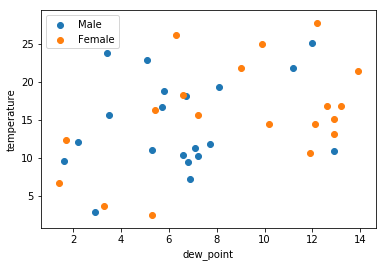

In [54]:
plt.scatter(x1[cat=='Male'],x2[cat=='Male'], label='Male')
plt.scatter(x1[cat=='Female'],x2[cat=='Female'], label='Female')
plt.xlabel('dew_point')
plt.ylabel('temperature')
plt.legend()
plt.show()

# 
# pressure_station  pressure sea 0.67
# pressure_station  wind_dir_10s  0.67
# pressure_station  wind_speed  0.67
# pressure_station  dew_point  0.718
# pressure_station  temperature  0.67
# health_index  0.67

# pressure sea  wind_dir_10s  0.69
# wind_speed  0.64
# dew_point  0.718
# temperature  0.615
# health_index  0.718

# wind_dir_10s  wind_speed  0.64
# dew_point  0.718
# temperature  0.615
# health_index  0.69

# wind_speed  dew_point  0.69
# temperature  0.67
# health_index  0.718

# dew_point  temperature  0.77
# health_index  0.69

# temperature  health_index  0.718
# 

#### Polynomial features

In [55]:
x3 = (x1,x2)
x3 = np.array(x3)
x3 = x3.T

poly_features = PolynomialFeatures(degree = 2)
X_poly = poly_features.fit_transform(x3)


#### Logistic regression with polynomial features and no regularization

In [56]:
logreg = linear_model.LogisticRegression(solver='lbfgs',multi_class='auto')
logreg.fit(X_poly,cat1)
Yp = logreg.predict(X_poly)
cm = confusion_matrix(cat1, Yp)
print(pd.DataFrame(cm))
tn, fp, fn, tp = cm.flatten()
tot = np.sum(cm)
print("Model accuracy:",(tn+tp)/tot)
print("Misclassified:",(fn+fp)/tot)
print("% of error of true No:",fn/(fn+tn)*100)
print("% of error of true Yes:",fp/(fp+tp)*100)

    0  1
0  16  4
1  10  9
Model accuracy: 0.6410256410256411
Misclassified: 0.358974358974359
% of error of true No: 38.46153846153847
% of error of true Yes: 30.76923076923077


#### Logistic regression with polynomial features and L2 regularization

In [57]:
logreg_r2 = linear_model.LogisticRegression(solver='lbfgs',multi_class='auto', penalty="l2")
logreg_r2.fit(X_poly,cat1)
Yp = logreg_r2.predict(X_poly)
cm = confusion_matrix(cat1, Yp)
print(pd.DataFrame(cm))
tn, fp, fn, tp = cm.flatten()
tot = np.sum(cm)
print("Model accuracy:",(tn+tp)/tot)
print("Misclassified:",(fn+fp)/tot)
print("% of error of true No:",fn/(fn+tn)*100)
print("% of error of true Yes:",fp/(fp+tp)*100)

    0  1
0  16  4
1  10  9
Model accuracy: 0.6410256410256411
Misclassified: 0.358974358974359
% of error of true No: 38.46153846153847
% of error of true Yes: 30.76923076923077


#### Logistic regression with polynomial features and L1 regularization

In [58]:
logreg_r1 = linear_model.LogisticRegression(solver='lbfgs',multi_class='auto', penalty="l1")
logreg_r.fit(X_poly,cat1)
Yp = logreg_r.predict(X_poly)
cm = confusion_matrix(cat1, Yp)
print(pd.DataFrame(cm))
tn, fp, fn, tp = cm.flatten()
tot = np.sum(cm)
print("Model accuracy:",(tn+tp)/tot)
print("Misclassified:",(fn+fp)/tot)
print("% of error of true No:",fn/(fn+tn)*100)
print("% of error of true Yes:",fp/(fp+tp)*100)

    0  1
0  16  4
1  10  9
Model accuracy: 0.6410256410256411
Misclassified: 0.358974358974359
% of error of true No: 38.46153846153847
% of error of true Yes: 30.76923076923077


As there is no difference observed (due to the small size of the dataset) only without regularization will be further taken into consideration

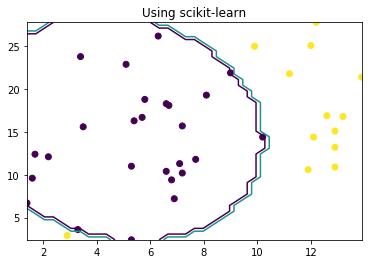

Model accuracy: 0.6410256410256411


In [59]:
xg = np.linspace(x1.min(), x1.max(), len(x1))
yg = np.linspace(x2.min(), x2.max(), len(x2))
xx, yy = np.meshgrid(xg,yg)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
Xcont = poly_features.fit_transform(np.vstack((xx.ravel(),yy.ravel())).T)
Z = logreg.predict(Xcont).reshape(xx.shape)
plt.contour(xx,yy,Z,levels=1)
plt.scatter(x1,x2,c=Yp)
plt.title("Using scikit-learn")
plt.show()
print("Model accuracy:",accuracy_score(cat1,Yp))

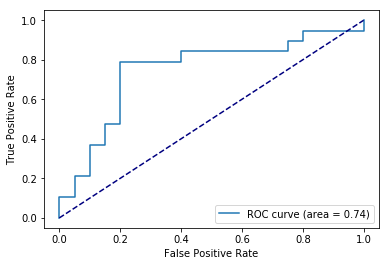

In [60]:
Yprob = logreg.predict_proba(X_poly)
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(cat1, Yprob[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## 2) SVM

In [61]:
def plot_svm_decision_margin(model, plot_support=True):
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   s=200, linewidth=1, edgecolors='black', facecolors='none');
    plt.show()

#### SVM with linear kernal

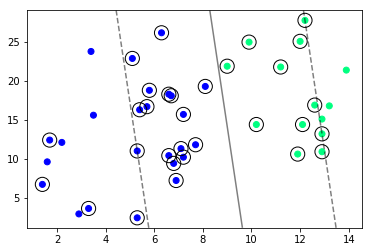

Soft Margin Model accuracity: 0.717948717948718


In [62]:
model_soft = SVC(kernel='linear')
model_soft.fit(x3, cat1)
Yp_soft = model_soft.predict(x3)
plt.scatter(x1, x2, c=Yp_soft, cmap='winter')
plot_svm_decision_margin(model_soft)
print("Soft Margin Model accuracity:",accuracy_score(cat1,Yp_soft))

#### SVM with rbf kernal

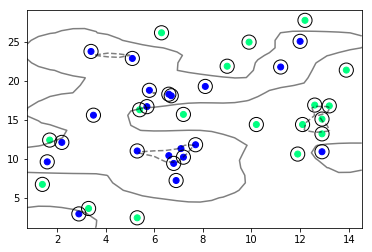

Soft Margin Model accuracity: 0.9743589743589743


In [63]:
model_soft_rbf = SVC(kernel='rbf')
model_soft_rbf.fit(x3, cat1)
Yp_soft = model_soft_rbf.predict(x3)
plt.scatter(x1, x2, c=Yp_soft, cmap='winter')
plot_svm_decision_margin(model_soft_rbf)
print("Soft Margin Model accuracity:",accuracy_score(cat1,Yp_soft))

## 3)